In [1]:
# Importing libraries
import pandas as pd, numpy as np, seaborn as sns, plotly.express as px, xgboost as XGB, matplotlib.pyplot as plt,plotly.graph_objects as go, math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Plot Customization
plt.figure(figsize = (15,9))
plt.style.context('bmh')

# Loading dataset
df = pd.read_csv('Employee-Attrition.csv')
df.head()

# Information on dataset
print(f'The dataset has {df.shape[0]} rows for each employee and {df.shape[1]} attributes\n')
print('='*80)
print('The attributes and their unique values are as below\n')
for i in df.columns:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)


# Dropping columns with little to no useful information
df = df.drop(['EmployeeCount',
                 'EmployeeNumber',
                 'Over18',
                  'StandardHours'],axis = 1)
df.columns


df.dtypes


# Unencoding Categorical Features
col = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction']

for i in df['Education']:
    df['Education'].replace({1:'Below College',2:'College',3:'Bachelor',4:'Master', 5:'Doctor'},
                       inplace = True)
    
for i in df['PerformanceRating']:
    df['PerformanceRating'].replace({1:'Low', 2:'Good',3:'Excellent',4:'Outstanding'},
                                  inplace = True)
    
for i in df['WorkLifeBalance']:
    df['WorkLifeBalance'].replace({1: 'Bad', 2:'Good', 3:'Better', 4:'Best'}, 
                                  inplace = True)

for i in df[col]:
    df[i].replace({1:'Low', 2:'Medium',3:'High', 4:'Very High'},
                   inplace = True)



# Checking new values for decoded attributes 
decoded = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction',
           'Education', 'PerformanceRating', 'WorkLifeBalance']

for i in df[decoded]:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)



# Checking for missing data
df.isnull().sum()



# Visualizing target variable classes and its distribution among the dataset
fig = px.pie(df, names = 'Attrition', title = 'Target Variable: Attrition', template = 'plotly_dark')
fig.update_traces(rotation=90, pull = [0.1], textinfo = "percent+label")
fig.show()



Attrition = df.query("Attrition == 'Yes'")
Attrition



print(f"{Attrition.shape[0]} emplyees in the dataset left the company.\n")





The dataset has 1470 rows for each employee and 35 attributes

The attributes and their unique values are as below

======== Age ========

35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: Age, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== Attrition ========

No     1233
Yes     237
Name: Attrition, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== BusinessTravel ========

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

237 emplyees in the dataset left the company.



<Figure size 1080x648 with 0 Axes>

In [2]:
# Splitting Dataset
X = df.drop('Attrition', axis = 1)
y = df.Attrition

In [3]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
print('X train size: ', len(X_train))
print('X test size: ', len(X_test))
print('y train size: ', len(y_train))
print('y test size: ', len(y_test))

X train size:  1029
X test size:  441
y train size:  1029
y test size:  441


The next step is encoding all categorical variables and I'll use both the Ordinal Encoder and the One Hot Encoder to do that.


It's important to remember that the Ordinal Encoder assumes an ordering of categories. So, for instance, when encoding Relationship Satisfaction, the encoding will assume that 'Low (0)' is lesser than 'Very High(3)'.


The One Hot Encoder, on the other way, will create new columns indicating the presence or absence of each possible value for every categorical attribute in our dataset, with binary values where 0 indicates the absence of each value and 1 indicates the presence of each value.


Categories such as Education and Job Involvement can easily be encoded with the Ordinal Encoder since there is some sort of hierarchy among their values, but Department, for instance, would be better encoded with the One Hot Encoder, since there is no department lesser or more than another.

In [4]:
# Enoding categorical variables with Ordinal Encoder
OE = OrdinalEncoder()
columns_OE = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
             'JobSatisfaction','WorkLifeBalance','PerformanceRating','RelationshipSatisfaction']
X_train[columns_OE] = OE.fit_transform(X_train[columns_OE])
X_test[columns_OE] = OE.transform(X_test[columns_OE])
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
871,24,2.0,984,Research & Development,17,2.0,Life Sciences,3.0,Female,97,...,0.0,1.0,1,1,3,0.0,1,0,0,0
1270,34,2.0,511,Sales,3,2.0,Life Sciences,3.0,Female,32,...,0.0,1.0,0,6,3,2.0,2,2,2,2
730,30,2.0,153,Research & Development,8,2.0,Life Sciences,2.0,Female,73,...,0.0,0.0,3,9,4,3.0,8,7,1,7
280,53,2.0,1070,Research & Development,3,4.0,Medical,0.0,Male,45,...,0.0,3.0,3,21,5,3.0,5,3,1,3
1435,44,2.0,1037,Research & Development,1,0.0,Medical,2.0,Male,42,...,0.0,0.0,0,6,2,2.0,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,24,2.0,1448,Sales,1,1.0,Technical Degree,1.0,Female,62,...,0.0,2.0,0,6,4,2.0,5,3,1,4
1197,20,2.0,727,Sales,9,1.0,Life Sciences,3.0,Male,54,...,0.0,1.0,0,2,3,2.0,2,2,0,2
840,35,2.0,982,Research & Development,1,4.0,Medical,3.0,Male,58,...,0.0,2.0,1,10,2,2.0,8,0,1,7
659,28,2.0,821,Sales,5,4.0,Medical,1.0,Male,98,...,0.0,2.0,0,4,3,2.0,4,2,0,2


In [5]:
# Transforming bicategoric variables into binary values
X_train['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_test['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_train['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)
X_test['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)

In [6]:
X_train.OverTime.value_counts()

0    750
1    279
Name: OverTime, dtype: int64

In [7]:
X_test.Gender.value_counts()

1    266
0    175
Name: Gender, dtype: int64

In [8]:
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
871,24,2.0,984,Research & Development,17,2.0,Life Sciences,3.0,0,97,...,0.0,1.0,1,1,3,0.0,1,0,0,0
1270,34,2.0,511,Sales,3,2.0,Life Sciences,3.0,0,32,...,0.0,1.0,0,6,3,2.0,2,2,2,2
730,30,2.0,153,Research & Development,8,2.0,Life Sciences,2.0,0,73,...,0.0,0.0,3,9,4,3.0,8,7,1,7
280,53,2.0,1070,Research & Development,3,4.0,Medical,0.0,1,45,...,0.0,3.0,3,21,5,3.0,5,3,1,3
1435,44,2.0,1037,Research & Development,1,0.0,Medical,2.0,1,42,...,0.0,0.0,0,6,2,2.0,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,24,2.0,1448,Sales,1,1.0,Technical Degree,1.0,0,62,...,0.0,2.0,0,6,4,2.0,5,3,1,4
1197,20,2.0,727,Sales,9,1.0,Life Sciences,3.0,1,54,...,0.0,1.0,0,2,3,2.0,2,2,0,2
840,35,2.0,982,Research & Development,1,4.0,Medical,3.0,1,58,...,0.0,2.0,1,10,2,2.0,8,0,1,7
659,28,2.0,821,Sales,5,4.0,Medical,1.0,1,98,...,0.0,2.0,0,4,3,2.0,4,2,0,2


In [9]:
# Enoding categorical variables with One Hot Encoder
OHE = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
columns_OHE = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']
X_train_cols = pd.DataFrame(OHE.fit_transform(X_train[columns_OHE]))
X_test_cols = pd.DataFrame(OHE.transform(X_test[columns_OHE]))
# Putting index back
X_train_cols.index = X_train.index
X_test_cols.index = X_test.index
# Removing categorical columns
num_X_train = X_train.drop([col for col in X_train.columns if X_train[col].dtype == "object"], axis = 1)
num_X_test = X_test.drop([col for col in X_test.columns if X_test[col].dtype == "object"], axis = 1)
# Adding one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train,X_train_cols ],axis = 1)
X_test = pd.concat([num_X_test, X_test_cols], axis = 1)

In [10]:
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
871,24,2.0,984,17,2.0,3.0,0,97,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1270,34,2.0,511,3,2.0,3.0,0,32,1.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
730,30,2.0,153,8,2.0,2.0,0,73,3.0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
280,53,2.0,1070,3,4.0,0.0,1,45,0.0,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1435,44,2.0,1037,1,0.0,2.0,1,42,0.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,24,2.0,1448,1,1.0,1.0,0,62,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1197,20,2.0,727,9,1.0,3.0,1,54,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
840,35,2.0,982,1,4.0,3.0,1,58,2.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
659,28,2.0,821,5,4.0,1.0,1,98,0.0,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [11]:
# Changing y values
print(y_train.value_counts())
print(y_test.value_counts())

No     861
Yes    168
Name: Attrition, dtype: int64
No     372
Yes     69
Name: Attrition, dtype: int64


In [12]:
y_train.replace({'No':0,
                'Yes':1}, inplace = True)
y_test.replace({'No':0,
                'Yes':1}, inplace = True)

In [13]:
print(y_train.value_counts())
print(y_test.value_counts())

0    861
1    168
Name: Attrition, dtype: int64
0    372
1     69
Name: Attrition, dtype: int64


We've seen before that our target variable is unbalanced, with much more 'No' values than 'Yes'.


I'll use SMOTE to synthetically create more 'Yes' values and have a 50/50 distribution for both classes during training. I prefer to oversample our minor class than undersampling the major class because I believe that undersampling may cause a loss of relevant data.

In [14]:
# Dealing with Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE
X_train,y_train = SMOTE().fit_resample(X_train,y_train)

In [15]:
y_train.value_counts()

1    861
0    861
Name: Attrition, dtype: int64

In [16]:
# Importing Models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

adaboost = AdaBoostClassifier()
randomforest = RandomForestClassifier()
gradientboosting = GradientBoostingClassifier()
decisiontree = DecisionTreeClassifier()
xgboost =  XGBClassifier()

In [17]:
# Creating a function for predictions
def predict(model):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_predict) * 100 ))
    print('Precision: %.2f%%' % (precision_score(y_test, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(y_test, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(y_test, y_predict) * 100))
    confusion_matrix_model = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(12,8))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

Accuracy: 79.82%
Precision: 39.13%
Recall: 52.17%
F1_Score: 44.72%


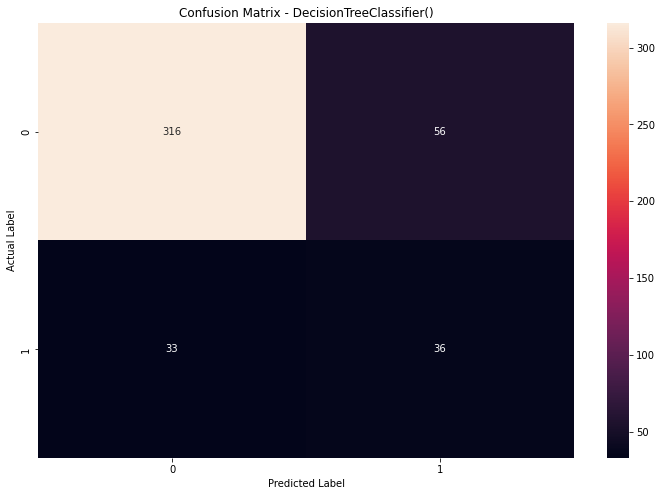

In [18]:
# Decision Tree
predict(decisiontree)

Accuracy: 85.49%
Precision: 60.00%
Recall: 21.74%
F1_Score: 31.91%


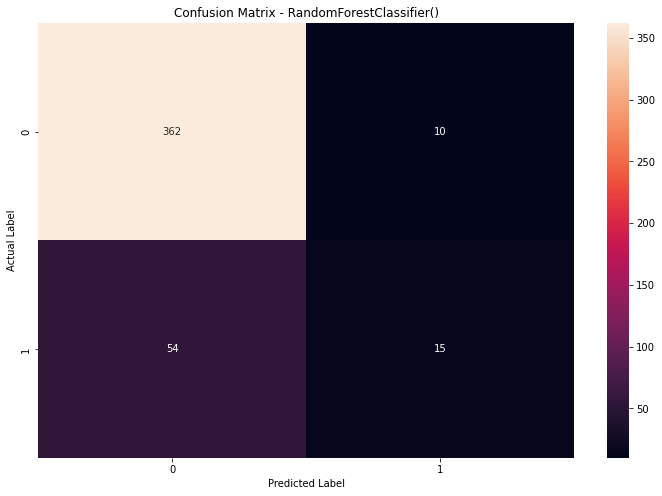

In [19]:
predict(randomforest)

Accuracy: 84.58%
Precision: 50.94%
Recall: 39.13%
F1_Score: 44.26%


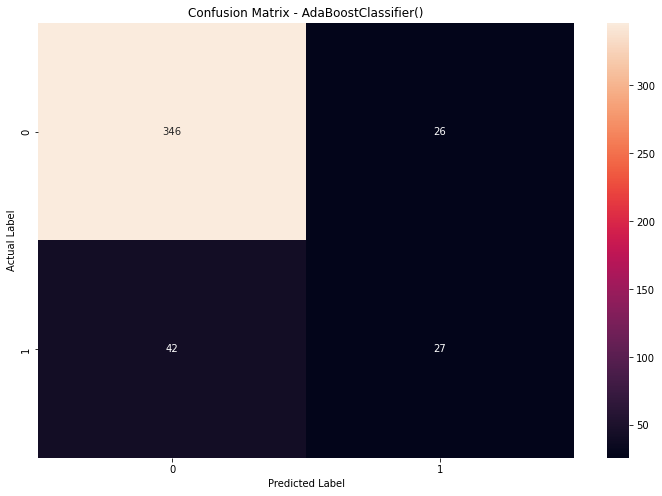

In [20]:
predict(adaboost)

Accuracy: 86.17%
Precision: 61.76%
Recall: 30.43%
F1_Score: 40.78%


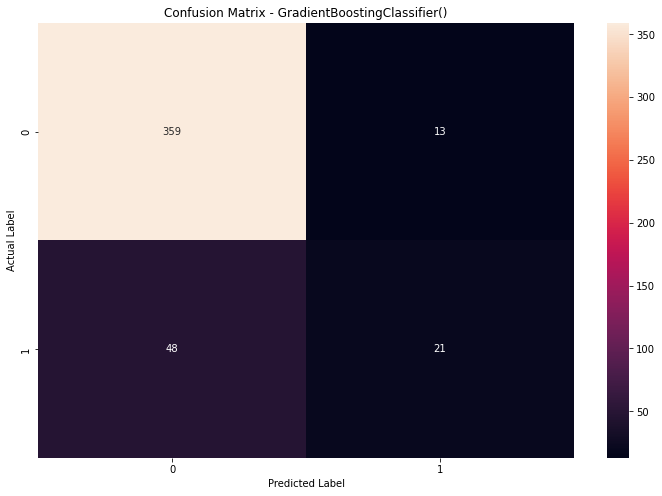

In [21]:
predict(gradientboosting)

Accuracy: 86.62%
Precision: 66.67%
Recall: 28.99%
F1_Score: 40.40%


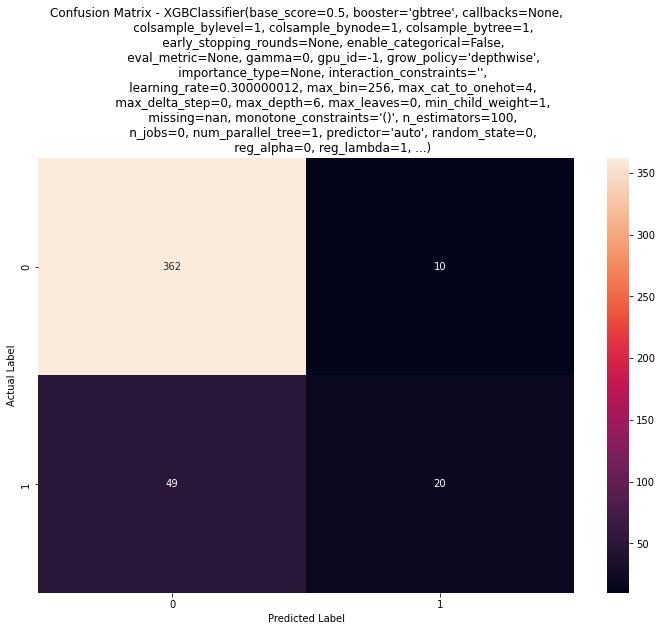

In [22]:
predict(xgboost)

AdaBoost Classifier had the best recall score, correctly predicting 35 out of 62 employees who left (56.45% of them).


Gradient Boosting had a better accuracy score (87.07%), making more correct predictions for both classes than any other model.


Considering the main goal to identify employees that are more likely to leave the company, the recall score is the one that I'm focusing on here. I don't believe that false positives would be expensive to deal with in this case, so I want the maximum amount of true positives as possible.


Let's use RandomSearchCV to tune our models and see if we can improve our results.


I'll abandon the decision tree classifier since it had the worst results of them all.

Hyperparameters

In [23]:
from sklearn.model_selection import RandomizedSearchCV

In [24]:
# Tunning Random Forest
randomforest_grid = {'n_estimators' : [100,150,200,250,300,350,400,450,500],
                    'max_depth':[5,1,15,20,25,30,40,50],
                    'criterion': ['gini','entropy'],
                    'min_samples_leaf':[2,5,8,10],
                    'min_samples_split': [2,5,8,10],
                    'max_features':['auto','sqrt']}
rf_tuning = RandomForestClassifier()
rf_search = RandomizedSearchCV(rf_tuning,param_distributions = randomforest_grid,
                              cv = 10, n_iter = 10, n_jobs = 1, verbose = 1, scoring = 'recall')
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 1, 15, 20, 25, 30, 40,
                                                      50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 8, 10],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   scoring='recall', verbose=1)

In [25]:
rf_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy'}

Accuracy: 84.58%
Precision: 52.00%
Recall: 18.84%
F1_Score: 27.66%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

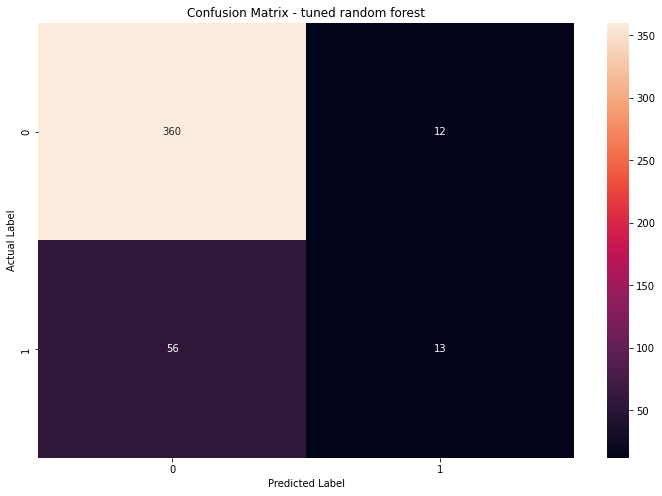

In [26]:
tuned_rf = RandomForestClassifier(**rf_search.best_params_)
tuned_rf.fit(X_train,y_train)
y_pred = tuned_rf.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned random forest')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [27]:
# Tuning Ada Boost
grid = {'n_estimators' : [50,100,500,1500,2000],
       'learning_rate' : [0.05,0.1,1.0,0.15,0.2,1.5,2.0],
       'algorithm': ['SAMME', 'SAMME.R']}

adaboost = RandomizedSearchCV(AdaBoostClassifier(),
                             param_distributions = grid,
                             cv = 10,
                             n_iter = 10,
                              n_jobs = 1, 
                              verbose = 1, 
                              scoring = 'recall')
adaboost.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.05, 0.1, 1.0, 0.15,
                                                          0.2, 1.5, 2.0],
                                        'n_estimators': [50, 100, 500, 1500,
                                                         2000]},
                   scoring='recall', verbose=1)

In [28]:
adaboost.best_params_

{'n_estimators': 1500, 'learning_rate': 1.0, 'algorithm': 'SAMME'}

Accuracy: 87.53%
Precision: 62.50%
Recall: 50.72%
F1_Score: 56.00%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

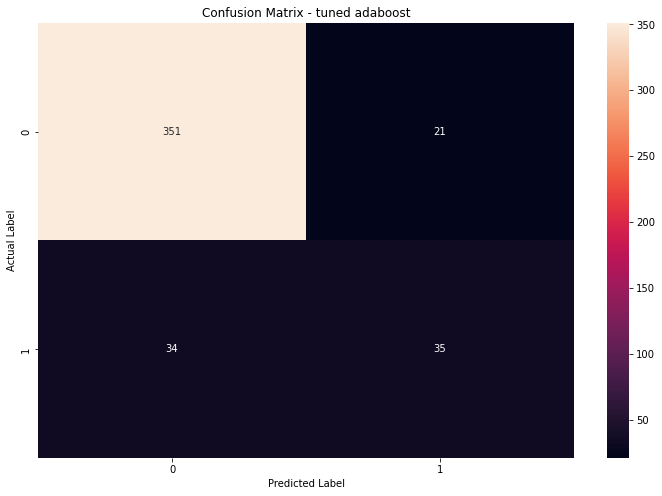

In [29]:
tuned_adaboost = AdaBoostClassifier(**adaboost.best_params_)
tuned_adaboost.fit(X_train,y_train)
y_pred = tuned_adaboost.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned adaboost')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [30]:
# Tuning Gradient Boosting
grid2 = {'n_estimators':[500,1000,1500,2000,2500],
        'learning_rate':[0.01,0.05,0.2,0.1,0.15,0.3,0.5],
        'min_samples_split':[2,5,6,10],
        'min_samples_leaf':[3,5,8,12],
        'criterion': ['friedman_mse', 'squared_error', 'mse'],
        'subsample': [0.1,0.2,0.5,0.6,0.8,1.0]}

gradientboosting = RandomizedSearchCV(GradientBoostingClassifier(),
                             param_distributions = grid2,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
gradientboosting.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'learning_rate': [0.01, 0.05, 0.2, 0.1,
                                                          0.15, 0.3, 0.5],
                                        'min_samples_leaf': [3, 5, 8, 12],
                                        'min_samples_split': [2, 5, 6, 10],
                                        'n_estimators': [500, 1000, 1500, 2000,
                                                         2500],
                                        'subsample': [0.1, 0.2, 0.5, 0.6, 0.8,
                                                      1.0]},
                   scoring='recall', verbose=1)

In [31]:
gradientboosting.best_params_

{'subsample': 0.5,
 'n_estimators': 1500,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'learning_rate': 0.15,
 'criterion': 'squared_error'}

Accuracy: 85.26%
Precision: 54.35%
Recall: 36.23%
F1_Score: 43.48%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

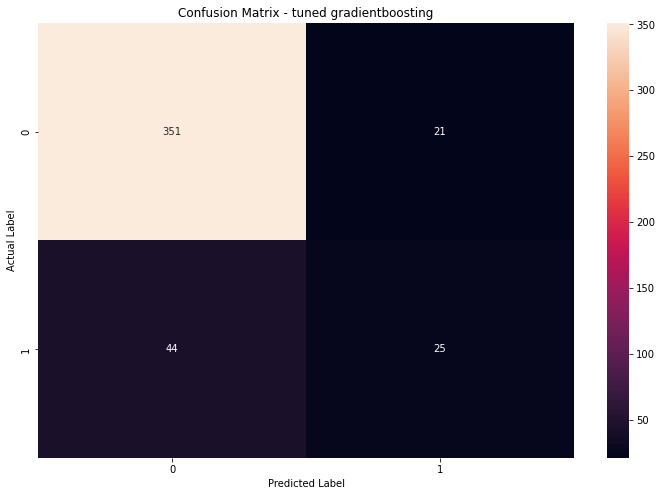

In [32]:
tuned_gradientboosting = GradientBoostingClassifier(**gradientboosting.best_params_)
tuned_gradientboosting.fit(X_train,y_train)
y_pred = tuned_gradientboosting.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned gradientboosting')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [33]:
# Tuning XGBoost Classifier
grid3 = {'n_estimators': [100,150,200,250,300,350,400,450,500],
              'learning_rate': [0.01, 0.5,0.2, 1.0],
              'subsample': [0.3,0.5, 0.6,0.8,1.0],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.2,0.5, 0.4,0.8,1.0],
              'min_child_weight': [1, 2, 3, 4]}
xgb = RandomizedSearchCV(XGBClassifier(),
                             param_distributions = grid3,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
xgb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=1,
                   param_distributions={'colsample_bytree': [0.2, 0.5, 0.4, 0.8,
                                                             1.0],
                                        'learning_rate': [0.01, 0.5, 0.2, 1.0],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500],
                                        'subsample': [0.3, 0.5, 0.6, 0.8, 1.0]},
                   scoring='recall', verbose=1)

In [34]:
xgb.best_params_

{'subsample': 0.3,
 'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning_rate': 0.5,
 'colsample_bytree': 0.5}

Accuracy: 84.58%
Precision: 50.75%
Recall: 49.28%
F1_Score: 50.00%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

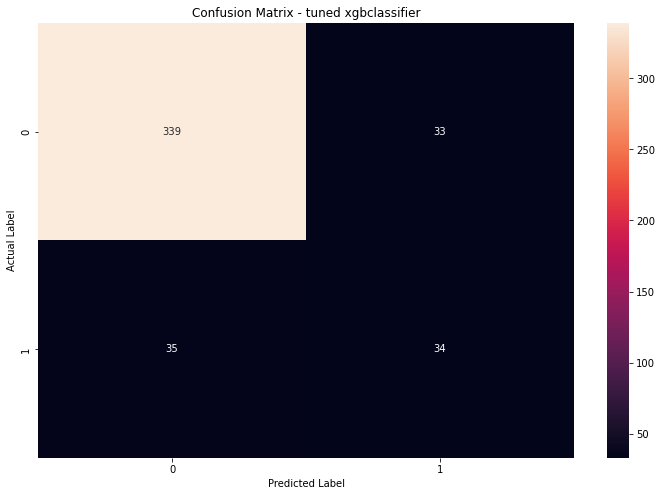

In [35]:
tuned_xgb = XGBClassifier(**xgb.best_params_)
tuned_xgb.fit(X_train,y_train)
y_pred = tuned_xgb.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned xgbclassifier')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

Conclusion

Through RandomizedSearchCV, we could improve the accuracy score for the Gradient Boosting Classifier, scoring 88.66%, the highest among all models.


Yet, the original Ada Boost Classifier model maintained the best recall score of 56.45%, correctly predicting the largest amount of employees who were more likely to leave.


Again, I believe that in this case, false positives wouldn't be much more expensive than false negatives, so I'm more interested in the model that predicted the largest amount of employees to leave, which was the first Ada Boost model built.